# Vision transformer model to analyze Lund Images
* The model based on 	arXiv:2010.11929 [cs.CV]
* The model analyze the same Lund Images for the CNN. The main difference that ViT is a transformer based model that can avoid the sparsity issue in the Lund Images
* We first batch the image into four batches with counter labels then we flatten all batches and feed them into the model
* The model consists of 5 self-attention heads and the transformer layer is repeated for 3 times

In [1]:
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm 
from keras.datasets import mnist, fashion_mnist,cifar10
from tensorflow.keras.utils import plot_model
import sklearn
from keras import backend as K # The backend is important while we are dealing with keras layers and the basic low level operation cannot be handeled by numpy
from keras.losses import mse, binary_crossentropy,CategoricalCrossentropy
from tqdm import tqdm  
import random    
# Import all the required Libraries
from sklearn.metrics import  roc_curve,auc
import tensorflow
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten,  Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras import regularizers
import os
from keras_nlp.layers import TransformerEncoder 
from scipy.ndimage import gaussian_filter

from keras_nlp.layers import TransformerEncoder 
from matplotlib.colors import LogNorm
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

if not tf.test.gpu_device_name():
    warnings.warn('No GPU found.....')
    sys.exit()
else:
    print('Default GPU device :{}'.format(tf.test.gpu_device_name()))
    
    

Using TensorFlow backend
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Default GPU device :/device:GPU:0


In [2]:
Images_SM = np.load('/Users/hammad/work/Lund/data/data_images/Images_SM.npz',allow_pickle=True)['arr_0']
Images_sig = np.load('/Users/hammad/work/Lund/data/data_images/Images_sig.npz',allow_pickle=True)['arr_0']

In [3]:
def flatten(t):
    return np.array([item for sublist in t for item in sublist])

In [4]:
im_SM = flatten(Images_SM)
im_sig = flatten(Images_sig)

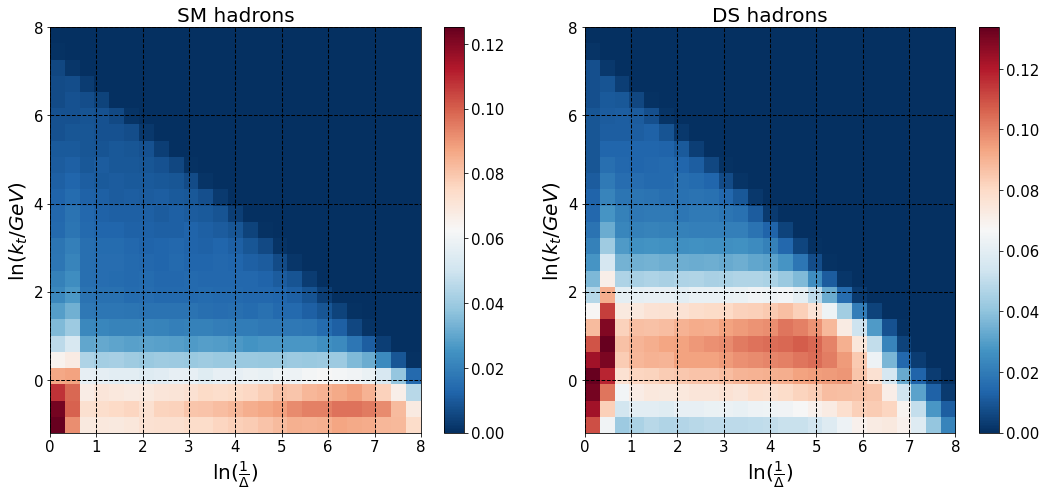

In [5]:
## Plot Lund Images for the SM and the DM
xval   = [0.0, 8.0]
yval   = [-1.2, 8.0]
fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=1, wspace=1)
y1 = fig.add_subplot(121)
c1=y1.imshow(np.average(im_SM[:90000],axis=0).T,origin='lower',aspect='auto',extent=xval+yval,cmap='RdBu_r')
y1.set_title(r'SM hadrons',fontsize=20)
y1.set_xlabel(r'$\ln(\frac{1}{\Delta})$',fontsize=20)
y1.set_ylabel(r'$\ln(k_t/GeV)$',fontsize=20)
plt.tick_params(axis='both',labelsize=15)
plt.colorbar(c1).ax.tick_params(labelsize=15)
y1.grid(color='k',linestyle='--',linewidth=1.01)

y2 = fig.add_subplot(122)
c2=y2.imshow(np.average(im_sig[:90000],axis=0).T,origin='lower',aspect='auto',extent=xval+yval,cmap='RdBu_r')
y2.set_title(r'DS hadrons',fontsize=20)
y2.set_xlabel(r'$\ln(\frac{1}{\Delta})$',fontsize=20)
y2.set_ylabel(r'$\ln(k_t/GeV)$',fontsize=20)
plt.tick_params(axis='both',labelsize=15)
plt.colorbar(c2).ax.tick_params(labelsize=15)
y2.grid(color='k',linestyle='--',linewidth=1.01)

plt.tight_layout()

In [6]:
# Transpose the images to get the right dimensions
imb = []
for i in range(len(im_SM)):
    imb.append(im_SM[i].T)

ims = []
for i in range(len(im_sig)):
    ims.append(im_sig[i].T)

    
im_s=np.array(ims).reshape(im_sig.shape[0],25,25)
im_b=np.array(imb).reshape(im_SM.shape[0],25,25)


In [7]:
# prepare the data for ViT

k =90_000
x1_data = np.concatenate((im_s[:k], im_b[:k]))
y1_data = np.array([1]*len(im_s[:k])+[0]*len(im_b[:k]))
x_data,y_data= sklearn.utils.shuffle(x1_data, y1_data) # shuffle both 

In [8]:
# Split the data to train and test data
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,shuffle=True, test_size=0.2)

In [9]:
# One more reshaping for the model
x_train= np.array(X_train).reshape(np.array(X_train).shape+(1,)).astype('float32')
x_test= np.array(X_test).reshape(np.array(X_test).shape+(1,)).astype('float32')
x_train.shape,x_test.shape

((144000, 25, 25, 1), (36000, 25, 25, 1))

In [10]:
##Hyper parameteres to be tuned
num_classes = 2
input_shape =(25,25,1)
batch_size=256
kernel_size = 6
epoch = 25
image_size = 25
num_heads = 10
num_transformers= 2
num_patches = (image_size // kernel_size) ** 2
projection_dim = 15
mlp_head_units = [128,64]
loss_func = keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [11]:
## function to batch the lund images before we feed it to ViT
## The function also add  a counter to label the batch position into the image
class Patches_extraction(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1], ## We can scale the output patches
            padding="VALID", ## To not keep the same output dimensions as input one
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) # (patch size, num_constit, features)
        return patches

Image size: 25x25
Number of patches: 16


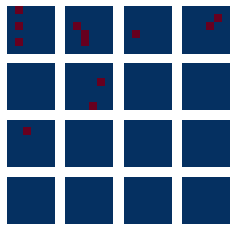

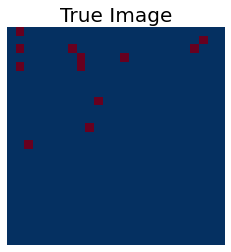

In [12]:
### Plot the first batched Lund Image together with the original one 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
b1 = Patches_extraction(kernel_size)(x_train)
im_num = 0
print(f'Image size: {image_size}x{image_size}')
print(f'Number of patches: {len(b1[1])}')

n = int(np.sqrt(b1.shape[1]))
fig = plt.figure(figsize=(4, 4))
for i in range(len(b1[im_num])):
    y = fig.add_subplot(n,n,i+1) 
    patch_im = tf.reshape(b1[im_num][i],(kernel_size,kernel_size,1))
    plt.imshow(patch_im,cmap='RdBu_r')
    plt.axis("off")
im = x_train[im_num].reshape(25,25)
plt.figure(figsize=(4, 4))
plt.imshow(im,cmap='RdBu_r')
plt.axis('off')
plt.title('True Image',fontsize=20);

In [13]:
### the final MLP layers
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Encode the patches with their positions 
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [14]:
transformer_encoder = TransformerEncoder(intermediate_dim=projection_dim, num_heads=num_heads,dropout=0.1)

In [15]:
## Create the ViT model 
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches_extraction(kernel_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformers):
        encoded_patches = transformer_encoder(encoded_patches)
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.2)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    out = layers.Dense(num_classes,activation='softmax')(features)
    model = keras.Model(inputs=inputs, outputs=out)
    return model

In [16]:
model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 25, 1)]          0         []                            
                                                                                                  
 patches_extraction_1 (Patc  (None, None, 36)             0         ['input_1[0][0]']             
 hes_extraction)                                                                                  
                                                                                                  
 patch_encoder (PatchEncode  (None, 16, 15)               795       ['patches_extraction_1[0][0]']
 r)                                                                                               
                                                                                              

In [17]:
### Training loop function per training batch 
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logit = model(x, training=True)
        loss_value = loss_func(y, logit)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_accuracy.update_state(y, logit)
    return loss_value,train_accuracy.result()

### function to test the loss and accuracy per training batch
@tf.function
def test_step(x, y):
    val_logit = model(x, training=False)
    test_accuracy.update_state(y, val_logit)
### Function to the test the model accuracy on the model test data    
def test_acc(model,x, y):
    val_logit = model(x, training=False)
    test_accuracy.update_state(y, val_logit)
    return print(f'Test Accuracy:  {test_accuracy.result()*100 :.3f}%')    

## Define the traning loop

def training_loop(model,x_train,y_train,epochs=20,batch_size=512):
    ## Lets create the batches first
    train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size) 
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_acc_avg = tf.keras.metrics.Mean()
    for epoch in range(epochs):
    # Iterate over the batches of the dataset.
        loss,acc = [],[]
        for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
            loss_value,acc_value = train_step(x_batch_train, y_batch_train)
            loss.append(loss_value)
            acc.append(acc_value)
            epoch_loss_avg.update_state(loss) 
            epoch_acc_avg.update_state(acc)  
            if step % 1 == 0:
                sys.stdout.write('\r'+'step %s :  loss = %2.5f  accuracy = %2.5f'%((step + 1),float(loss_value),float(acc_value)))
           
        # Display metrics at the end of each epoch.
        tf.print('|   Epoch {:2d}:  Loss (Avg): {:2.5f}  Accuracy (Avg): {:2.5f}'.format(epoch+1,epoch_loss_avg.result(),epoch_acc_avg.result()))  
        # Reset training metrics at the end of each epoch
        train_accuracy.reset_states()

In [18]:
training_loop(model,x_train,y_train,epochs=epoch,batch_size=batch_size)

step 563 :  loss = 0.22447  accuracy = 0.91094|   Epoch  1:  Loss (Avg): 0.24401  Accuracy (Avg): 0.84963
step 563 :  loss = 0.16244  accuracy = 0.92674|   Epoch  2:  Loss (Avg): 0.21544  Accuracy (Avg): 0.88802
step 563 :  loss = 0.09407  accuracy = 0.92786|   Epoch  3:  Loss (Avg): 0.20451  Accuracy (Avg): 0.90165
step 563 :  loss = 0.25694  accuracy = 0.92883|   Epoch  4:  Loss (Avg): 0.19854  Accuracy (Avg): 0.90845
step 563 :  loss = 0.20284  accuracy = 0.92994|   Epoch  5:  Loss (Avg): 0.19442  Accuracy (Avg): 0.91235
step 563 :  loss = 0.25959  accuracy = 0.93121|   Epoch  6:  Loss (Avg): 0.19117  Accuracy (Avg): 0.91532
step 563 :  loss = 0.13071  accuracy = 0.93172|   Epoch  7:  Loss (Avg): 0.18894  Accuracy (Avg): 0.91732
step 563 :  loss = 0.13196  accuracy = 0.93152|   Epoch  8:  Loss (Avg): 0.18702  Accuracy (Avg): 0.91911
step 563 :  loss = 0.14235  accuracy = 0.93142|   Epoch  9:  Loss (Avg): 0.18544  Accuracy (Avg): 0.92053
step 563 :  loss = 0.09559  accuracy = 0.93290

In [19]:
test_acc(model,x_test,y_test)

Test Accuracy:  93.553%


1125/1125 [==============================] - 11s 10ms/step


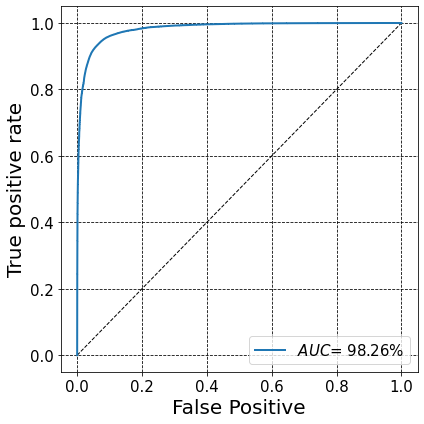

In [20]:
score=model.predict(x_test);
fpr, tpr,_ =roc_curve(tf.keras.utils.to_categorical(y_test,2).ravel(),score.ravel());
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'k--',linewidth=1);
plt.plot(fpr,tpr,linewidth=2,label=r'$AUC$= {:.2f}%'.format(float(auc(fpr, tpr))*100));
plt.xlabel(r'False Positive',fontsize=20,c='k');
plt.ylabel(r'True positive rate',fontsize=20,c='k');
plt.grid(linestyle='--',c='k')
plt.legend(loc='best',fontsize=15);
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()

In [21]:
np.savetxt('fpr_Lund_ViT.txt',fpr);
np.savetxt('tpr_Lund_ViT.txt',tpr);